In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os, sys

In [2]:
sys.path.append(os.path.abspath('../'))
import sfr_methods

In [3]:
plt.style.use('seaborn')
plt.style.use('seaborn-colorblind')

In [4]:
usable_paths = np.load('../usable_v3_paths.npy')

In [5]:
def load_dict(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [6]:
dict_list = []
df_list = []

for path in usable_paths:
    filename = path.split('/')[-1].split('.')[0]
    
    galdict = load_dict('../Form_Resources/Dicts_Avg_SFR_Thresholds/' + filename + '.dict.pkl')
    galdf = pd.read_pickle('../Form_Resources/DFs/' + filename + '.df.pkl')
    
    dict_list.append(galdict)
    df_list.append(galdf)

In [7]:
comb_df = pd.concat(df_list)

In [8]:
comb_df = comb_df.dropna()
comb_df = comb_df[(comb_df['$r/r_e$'] > 0.1) & (comb_df['$r/r_e$'] < 1.5)]
comb_df = comb_df[(comb_df['Comp'] == 0) & (comb_df['AGN'] == 0) & (comb_df['Seyfert'] == 0) & (comb_df['Liner'] == 0)]
comb_df = comb_df[comb_df['S/N $H_{\\alpha}$'] > 0]
comb_df = comb_df[(comb_df['Spiral Arm (3, 3)'] == True) | (comb_df['Nonspiral Arm (3, 3)'] == True)]

In [10]:
comb_df = comb_df[2 * (comb_df['$\\sigma H_{\\alpha}$']) < comb_df['$H_{\\alpha}$']]

In [11]:
comb_df

,Radius,$H_{\alpha}$,$\sigma H_{\alpha}$,S/N $H_{\alpha}$,$H_{\beta}$,$\sigma H_{\beta}$,S/N $H_{\beta}$,Comp,AGN,Seyfert,...,"Spiral Arm (7, 3)","Nonspiral Arm (7, 3)","Spiral Arm (7, 4)","Nonspiral Arm (7, 4)","Spiral Arm (7, 5)","Nonspiral Arm (7, 5)","Spiral Arm (7, 6)","Nonspiral Arm (7, 6)","Spiral Arm (7, 7)","Nonspiral Arm (7, 7)"
959,23.332847,1.001042,0.033741,29.668041,0.234235,0.031065,7.540092,0.0,0.0,0.0,...,False,True,False,True,False,True,False,True,False,True
960,23.048731,0.997163,0.035224,28.309196,0.219129,0.030717,7.133813,0.0,0.0,0.0,...,False,True,False,True,False,True,False,True,False,True
961,22.809584,1.134732,0.034760,32.644814,0.246389,0.033095,7.444842,0.0,0.0,0.0,...,False,True,False,True,False,True,False,True,False,True
962,22.616832,1.252236,0.039800,31.463034,0.296223,0.038347,7.724748,0.0,0.0,0.0,...,False,True,False,True,False,True,False,True,False,True
963,22.471668,1.360757,0.039833,34.161678,0.354649,0.038299,9.260021,0.0,0.0,0.0,...,False,True,False,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4772,27.521702,4.029562,0.312460,12.896239,6.044775,0.164695,36.702877,0.0,0.0,0.0,...,False,True,False,True,False,True,False,True,False,True
4776,27.905503,1.070010,0.155873,6.864638,1.946371,0.139676,13.934880,0.0,0.0,0.0,...,False,True,False,True,False,True,False,True,False,True
4777,28.186244,0.364832,0.032370,11.270699,0.125411,0.033873,3.702409,0.0,0.0,0.0,...,False,True,False,True,False,True,False,True,False,True
4782,30.590433,0.320606,0.038201,8.392575,0.176520,0.036300,4.862848,0.0,0.0,0.0,...,False,True,False,True,False,True,False,True,False,True


In [12]:
def get_radial_sfrs(bins, comb_df):
    props = []
    sig_props = []
    
    df = comb_df.copy()
    
    binned_dfs = []
    for rbin in bins:
        rdf = df[(df['$r/r_e$'] > rbin[0]) & (df['$r/r_e$'] <= rbin[1])]
        binned_dfs.append(rdf)
    
    for i in range(len(binned_dfs)):
        binned_df = binned_dfs[i]
        prop, sig_prop = sfr_props(binned_df, comb_df)
        
        props.append((bins[i], prop))
        sig_props.append((bins[i], sig_prop))
        
        print('RADIAL BIN NUMBER', i, '\n')
        
    return props, sig_props

In [13]:
def sfr_props(rdf, comb_df):
    mangaids = rdf['MaNGA ID'].unique()
    
    spiral_avgs = []
    sig_spiral_avgs = []
    nspiral_avgs = []
    sig_nspiral_avgs = []
    
    for mangaid in mangaids:
        galaxy_df = rdf[rdf['MaNGA ID'] == mangaid]
        
        galaxy_df_spiral = galaxy_df[(galaxy_df['Spiral Arm (3, 3)'] == True) & (galaxy_df['Nonspiral Arm (3, 3)'] == False)]
        galaxy_df_nspiral = galaxy_df[galaxy_df['Nonspiral Arm (3, 3)'] == True]
        
        galdict, galdf = ret_dict_df(mangaid)
        
        avg_spiral_sfr, sig_avg_spiral_sfr = sfr_methods.get_sfr(galaxy_df_spiral.index, galdf, galdict, avg=True)
        avg_nspiral_sfr, sig_avg_nspiral_sfr = sfr_methods.get_sfr(galaxy_df_nspiral.index, galdf, galdict, avg=True)
        
        #if (avg_spiral_sfr > 10:
        
        if not (avg_spiral_sfr == 0):
            spiral_avgs.append(avg_spiral_sfr)
            sig_spiral_avgs.append(sig_avg_spiral_sfr)
            
        if not (avg_nspiral_sfr == 0):
            nspiral_avgs.append(avg_nspiral_sfr)
            sig_nspiral_avgs.append(sig_avg_nspiral_sfr)
            
    if (len(spiral_avgs) == 0) or (len(nspiral_avgs) == 0):
        return 'N/A', 'N/A'
    
    avg_spiral, sig_avg_spiral = ret_averaged_sfrs(spiral_avgs, sig_spiral_avgs)
    avg_nspiral, sig_avg_nspiral = ret_averaged_sfrs(nspiral_avgs, sig_nspiral_avgs)
        
    prop = (avg_spiral - avg_nspiral) / avg_nspiral
    sig_prop = prop * ((sig_avg_spiral / avg_spiral)**2 + (sig_avg_nspiral / avg_nspiral)**2)**0.5
        
    return prop, sig_prop

In [14]:
def ret_dict_df(mangaid):
    for i in range(len(dict_list)):
        if dict_list[i]['mangaid'] == mangaid:
            return dict_list[i], df_list[i]
    
    print('No galaxy Dict or DF found for MaNGA ID:', mangaid)

In [15]:
def ret_averaged_sfrs(sfrs, sig_sfrs):
    sfrs = np.array(sfrs)
    sig_sfrs = np.array(sig_sfrs)
        
    variances = np.square(sig_sfrs)
    sum_variances = variances.sum()
    avg_variance = sum_variances / len(sig_sfrs)**2
    avg_stdv = np.sqrt(avg_variance)
    
    mean = sfrs.mean()
        
    return mean, avg_stdv

In [16]:
def ret_bins(a, b, n):
    bins = []
    binvals = np.linspace(a, b, n)
    
    for i in range(1, len(binvals)):
        bins.append((binvals[i - 1], binvals[i]))
        
    return bins

In [17]:
bins = ret_bins(0.1, 1.5, 2)

In [18]:
bins

[(0.1, 1.5)]

In [19]:
outputs = get_radial_sfrs(bins, comb_df)

RADIAL BIN NUMBER 0 



In [20]:
overall_props = []
sig_overall_props = []

for overall_prop in outputs[0]:
    overall_props.append(overall_prop[1])
    
for sig_overall_prop in outputs[1]:
    sig_overall_props.append(sig_overall_prop[1])

In [21]:
avg_bins = []

for element in bins:
    avg = (element[0] + element[1]) / 2
    avg_bins.append(avg)

<ErrorbarContainer object of 3 artists>

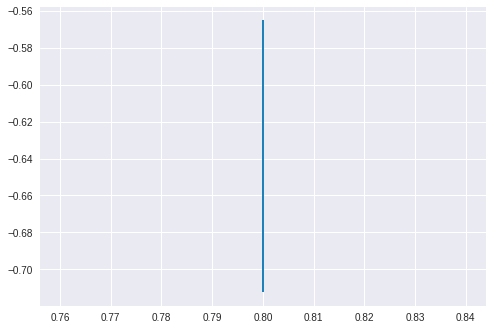

In [22]:
plt.errorbar(avg_bins, overall_props, yerr=sig_overall_props)
#plt.ylim(-2.5, 2.5)